In [2]:
#1 Analyze Data
#2 Split(train & validation) data
#3 Transform(normalization & augmentation) data
#4 DataLoader (train & validation)
#5 Create device selection function
#6 Create General function
#7 Create ResNet9 function
#8 Create Training function
#9 Wrap Loaded Data with prefered device(GPU/CPU)
#10 Evaluate loss & accuracy before train model
#11 Train model
#12 Evaluate loss & accuracy after train model
#13 Create single input function
#14 Save trained model

In [4]:
import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as tt

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split, Dataset
from torchvision.utils import make_grid

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [6]:
#1 Analyze Data
data_dir = './data'

print(os.listdir(data_dir))

['Testing', 'Training']


In [8]:
dataset = ImageFolder(data_dir + '/Training', transform = ToTensor())
img, label = dataset[0]

print(img.shape,label)

torch.Size([3, 512, 512]) 0


In [10]:
# Initialize variables to store the min and max shapes
min_shape = None
max_shape = None

# Iterate through the dataset
for img, _ in dataset:
    # Get the shape of the image (which is a tensor after the ToTensor transform)
    shape = img.shape  # (C, H, W), where C is channels, H is height, W is width
    
    # Update the min and max shapes
    if min_shape is None or shape[1:] < min_shape[1:]:
        min_shape = shape
    if max_shape is None or shape[1:] > max_shape[1:]:
        max_shape = shape

print(f"Minimum image shape: {min_shape[1:]}")  # Excluding channels (C)
print(f"Maximum image shape: {max_shape[1:]}")

Minimum image shape: torch.Size([168, 300])
Maximum image shape: torch.Size([1446, 1375])


In [12]:
# Group of probability
print(os.listdir(data_dir + '/Training'))
print(os.listdir(data_dir + '/Testing'))

['glioma', 'meningioma', 'notumor', 'pituitary']
['glioma', 'meningioma', 'notumor', 'pituitary']


In [14]:
# Length and file type of sample
glioma_train_file = os.listdir(data_dir + '/Training/glioma')
meningioma_train_file = os.listdir(data_dir + '/Training/meningioma')
notumor_train_file = os.listdir(data_dir + '/Training/notumor')
pituitary_train_file = os.listdir(data_dir + '/Training/pituitary')

glioma_test_file = os.listdir(data_dir + '/Testing/glioma')
meningioma_test_file = os.listdir(data_dir + '/Testing/meningioma')
notumor_test_file = os.listdir(data_dir + '/Testing/notumor')
pituitary_test_file = os.listdir(data_dir + '/Testing/pituitary')

print('No. of train glioma example:', len(glioma_train_file))
print('No. of train meningioma example:', len(meningioma_train_file))
print('No. of train no tumor example:', len(notumor_train_file))
print('No. of train pituitary example:', len(pituitary_train_file))

print('No. of test glioma example:', len(glioma_test_file))
print('No. of test meningioma example:', len(meningioma_test_file))
print('No. of test no tumor example:', len(notumor_test_file))
print('No. of test petuitary example:', len(pituitary_test_file))

print(glioma_train_file[:3])
print(glioma_test_file[:3])

No. of train glioma example: 1321
No. of train meningioma example: 1339
No. of train no tumor example: 1595
No. of train pituitary example: 1457
No. of test glioma example: 300
No. of test meningioma example: 306
No. of test no tumor example: 405
No. of test petuitary example: 300
['Tr-glTr_0000.jpg', 'Tr-glTr_0001.jpg', 'Tr-glTr_0002.jpg']
['Te-glTr_0000.jpg', 'Te-glTr_0001.jpg', 'Te-glTr_0002.jpg']


In [16]:
print('Total train data:', 1321+1339+1595+1457)
print('Total test data:', 300+306+405+300)

Total train data: 5712
Total test data: 1311


In [18]:
#Dataset mean & std (For data transformation)
import torchvision.datasets as datasets
data_transforms = tt.Compose([
    tt.Resize((32,32)),
    tt.ToTensor()
])

train_dataset = ImageFolder(data_dir + '/Training',
                            transform = data_transforms)
train_loader = DataLoader(dataset = train_dataset,
                         batch_size = 16,
                         shuffle = True)
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0,0,0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    return mean,std

mean, std = get_mean_std(train_loader)
print('mean:',mean)
print('std:',std)

mean: tensor([0.1856, 0.1856, 0.1856])
std: tensor([0.1744, 0.1744, 0.1744])


In [22]:
#2 Split(train & validation) data
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import Dataset

train_dataset = ImageFolder(data_dir +'/Training')
test_dataset = ImageFolder(data_dir +'/Testing')

random_seed = 42
torch.manual_seed(random_seed);
val_size = 571
train_size = len(dataset) - val_size

train_datas, val_datas = random_split(train_dataset, [train_size, val_size])
test_datas = test_dataset
len(train_datas), len(val_datas),len(test_datas)

(5141, 571, 1311)

In [24]:
'''
If data is too small, train with all training dataset and validate with all testing dataset

train_ds = ImageFolder(data_dir+'/Training', train_tfms)
valid_ds = ImageFolder(data_dir+'/Testing', valid_tfms)
'''

"\nIf data is too small, train with all training dataset and validate with all testing dataset\n\ntrain_ds = ImageFolder(data_dir+'/Training', train_tfms)\nvalid_ds = ImageFolder(data_dir+'/Testing', valid_tfms)\n"

In [26]:
#3 Transform(normalization & augmentation) data
stats = ((0.1856, 0.1856, 0.1856), (0.1744, 0.1744, 0.1744))
train_tfms = tt.Compose([tt.Resize((32,32)),
                         tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize((32,32)),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])
test_tfms = tt.Compose([tt.Resize((32,32)),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])

In [28]:
train_ds = ImageFolder(data_dir + '/Training', transform = train_tfms)
train_ds = Subset(train_ds, train_datas.indices)

val_ds = ImageFolder(data_dir + '/Training', transform = valid_tfms)
val_ds = Subset(val_ds, val_datas.indices)

test_ds = ImageFolder(data_dir +'/Testing', test_tfms)

len(train_ds), len(val_ds), len(test_ds)

(5141, 571, 1311)

In [30]:
#4 DataLoader (train & validation)
batch_size = 16

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)
# test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

In [32]:
#5 Create device selection function
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [34]:
#6 Create General function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [36]:
#7 Create ResNet9 function
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 3 x 32 x 32
        self.conv1 = conv_block(in_channels, 64) # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512 x 1 x 1
                                        nn.Flatten(), # 512
                                        nn.Dropout(0.2), # 512
                                        nn.Linear(512, num_classes)) # 4(output probability)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

model = to_device(ResNet9(3, 4), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [38]:
#8 Create Training function
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [40]:
#9 Wrap Loaded Data with prefered device(GPU/CPU)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
#test_dl = DeviceDataLoader(test_dl, device)

In [42]:
#10 Evaluate loss & accuracy before train model
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.3838880062103271, 'val_acc': 0.2890303432941437}]

In [46]:
#11 Train model
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [48]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.0015, train_loss: 0.9079, val_loss: 0.5042, val_acc: 0.8346
Epoch [1], last_lr: 0.0044, train_loss: 0.8706, val_loss: 0.5831, val_acc: 0.8088
Epoch [2], last_lr: 0.0076, train_loss: 0.9468, val_loss: 1.1598, val_acc: 0.5315
Epoch [3], last_lr: 0.0097, train_loss: 0.9230, val_loss: 0.4402, val_acc: 0.8540
Epoch [4], last_lr: 0.0099, train_loss: 0.7658, val_loss: 1.1520, val_acc: 0.5756
Epoch [5], last_lr: 0.0095, train_loss: 0.6076, val_loss: 0.4285, val_acc: 0.8480
Epoch [6], last_lr: 0.0087, train_loss: 0.5276, val_loss: 0.3488, val_acc: 0.8691
Epoch [7], last_lr: 0.0075, train_loss: 0.4388, val_loss: 0.2337, val_acc: 0.9198
Epoch [8], last_lr: 0.0061, train_loss: 0.3730, val_loss: 0.3127, val_acc: 0.8931
Epoch [9], last_lr: 0.0046, train_loss: 0.2927, val_loss: 0.1866, val_acc: 0.9320
Epoch [10], last_lr: 0.0032, train_loss: 0.2744, val_loss: 0.2908, val_acc: 0.8852
Epoch [11], last_lr: 0.0019, train_loss: 0.1952, val_loss: 0.1376, val_acc: 0.9504
Epoch [12], la

In [50]:
#12 Evaluate loss & accuracy after train model
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

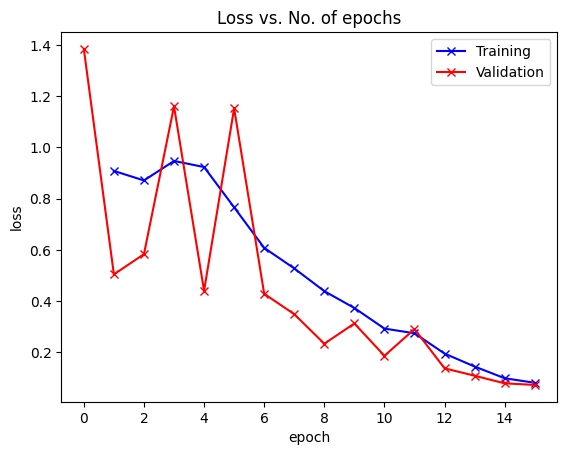

In [52]:
plot_losses(history)

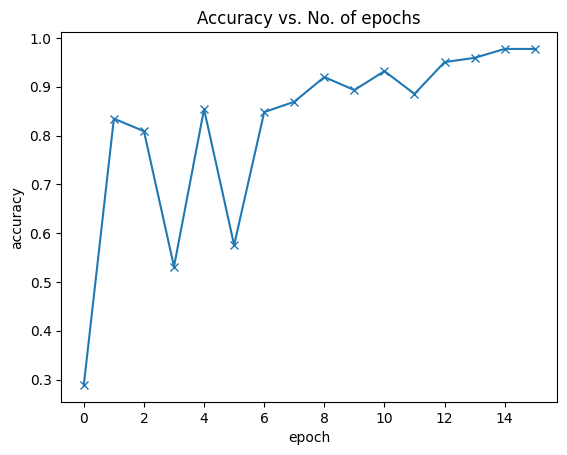

In [54]:
plot_accuracies(history)

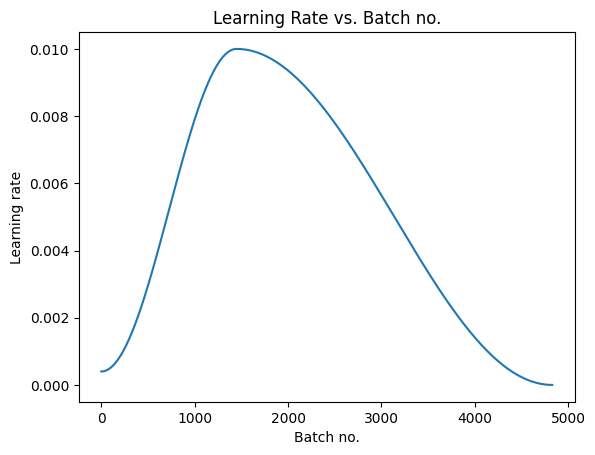

In [56]:
plot_lrs(history)

In [58]:
#13 Create single input function
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

Label: meningioma , Predicted: meningioma


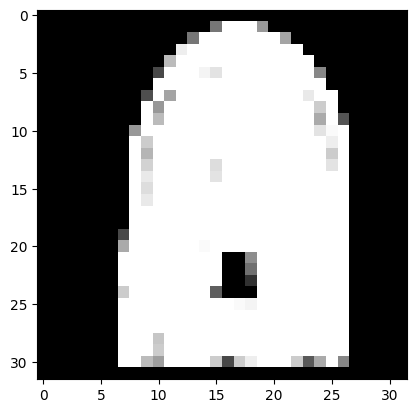

In [62]:
img, label = test_ds[300]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [64]:
#14 Save trained model

# .pth
# torch.save(model.state_dict(), '03.1_brain_tumor.pth')

# .pkl
# with open('resnet9.pkl','wb') as file:
#    pickle.dump(model,file)